# Introduction: Causal Inference with Propensity Score Matching (PSM) and ATT

In this session, we will learn how to estimate the **causal effect** of a treatment or intervention (e.g., job training) on an outcome (e.g., annual earnings) using real observational data. We’ll focus on the **Average Treatment effect on the Treated (ATT)** with the help of **Propensity Score Matching (PSM)**.

---

## 1. Why Causal Inference?

Many questions in social science and policy require estimating the effect of an action, not just associations.

- **Causal inference** helps answer: *What would have happened if a group had (or had not) received the treatment?*

---

## 2. The Potential Outcomes Framework

- Each individual has two potential outcomes:
    - $ Y(1) $: Outcome if treated
    - $ Y(0) $: Outcome if not treated
- **Fundamental problem:** We observe only one outcome per individual (cannot see both worlds).
- The **ATT** asks: *For those who actually got the treatment, what is the average effect?*

\[
ATT = E[Y(1) - Y(0) | T=1]
\]

---

## 3. What is the Propensity Score?

- The **propensity score**: $ e(x) = P(T=1 \mid X=x) $
    - It is the probability of receiving the treatment, given observed covariates.
- Balancing on $ e(x) $ (by matching or weighting) helps us compare “similar” individuals who did and didn’t receive the treatment.

---

## 4. Steps in PSM + ATT

1. **Specify covariates:** Variables that affect both treatment and outcome.
2. **Estimate propensity scores:** Usually with logistic regression.
3. **Match treated to control units:** Find controls with similar propensity scores (nearest neighbor).
4. **Estimate ATT:** Compare outcomes between treated subjects and their matched controls.
5. **Check balance:** After matching, covariates should be similar across groups.

---

## 5. Why Logistic Regression for Propensity Scores?

- Logistic regression estimates $P(T=1\mid X)$ flexibly with binary treatments.
- Well-understood, transparent, and provides propensity scores on the $[0,1]$ scale.
- Can be extended for non-linearities or interactions if needed.

---

## 6. Key Assumptions in PSM

- **Unconfoundedness (Selection on Observables):** All covariates affecting treatment assignment and outcome are observed and included.
- **Overlap (Common Support):** For every combination of covariates, there is a positive probability of being both treated and control (no “types” who always/never get treatment).
- **Correct model specification:** The propensity score model must be well-specified (correct covariates, functional form).

---

## 7. Why Do We Use PSM?

- In observational data, treated and control units might systematically differ.
- PSM helps create a synthetic control group similar to the treatment group, mimicking random assignment.
- Reduces selection bias due to observed confounders.

---

**In summary:**  
We’ll use the LaLonde dataset to demonstrate how PSM can help estimate the causal effect (ATT) of job training on earnings, highlighting both the mechanics and the crucial assumptions that must hold for valid inference.


## Loading lalonde from the dowhy, (as dowhy is a very handy library to work on causal inference - both potential outcomes, and pearl's causa hierarchy)


In [4]:
import dowhy.datasets

lalonde = dowhy.datasets.lalonde_dataset()

In [5]:
lalonde.head()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75
0,False,23.0,10.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00,1.0,1.0
1,False,26.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,12383.68,1.0,1.0
2,False,22.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00,1.0,1.0
3,False,18.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,10740.08,1.0,1.0
4,False,45.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,11796.47,1.0,1.0


Data Dictionary :
| Covariate | Type       | Description                                                                         |
| --------- | ---------- | ----------------------------------------------------------------------------------- |
| age       | Continuous | Age of the individual (in years)                                                    |
| educ      | Continuous | Years of education completed                                                        |
| black     | Binary     | 1 if the individual identifies as Black, 0 otherwise                                |
| hispan    | Binary     | 1 if the individual identifies as Hispanic, 0 otherwise                             |
| married   | Binary     | 1 if the individual is married, 0 otherwise                                         |
| nodegree  | Binary     | 1 if the individual doesnothave a high school diploma (no degree), 0 if has diploma |
| re74      | Continuous | Earnings in 1974 (before treatment), in US dollars                                  |
| re75      | Continuous | Earnings in 1975 (before treatment), in US dollars                                  |

In [6]:
import statsmodels.api as sm

def estimate_propensity_score(df, covariate_cols, treat_col):
    X = df[covariate_cols]
    X = sm.add_constant(X)
    y = df[treat_col]
    logit_model = sm.Logit(y, X)
    fit = logit_model.fit(disp=0)
    propensity_scores = fit.predict(X)
    return propensity_scores, fit

In [7]:
import matplotlib.pyplot as plt

def plot_pscore_histograms(df, pscore_col, treat_col):
    plt.hist(df[df[treat_col] == 1][pscore_col], bins=20, alpha=0.6, label='Treated')
    plt.hist(df[df[treat_col] == 0][pscore_col], bins=20, alpha=0.6, label='Control')
    plt.xlabel("Propensity Score")
    plt.ylabel("Count")
    plt.legend()
    plt.title("Propensity Score Distribution")
    plt.show()

In [8]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def nearest_neighbor_match(df, pscore_col, treat_col, k_neighbors=1):
    treated = df[df[treat_col] == 1].copy()
    control = df[df[treat_col] == 0].copy()
    
    nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto').fit(control[[pscore_col]])
    distances, indices = nbrs.kneighbors(treated[[pscore_col]])
    
    matched_idx = control.index[indices.flatten()]
    
    # 1:1: Each treated is matched with its nearest control; for 1:K, rows will repeat
    matched_controls = control.loc[matched_idx]
    matched_controls.index = treated.index  # align index for direct subtraction
    
    return treated, matched_controls

In [9]:
def calculate_att(treated, matched_controls, outcome_col):
    # For 1:K, just flatten and take mean difference
    att = (treated[outcome_col].values - matched_controls[outcome_col].values).mean()
    return att

In [10]:
def plot_covariate_balance(df, matched_treated, matched_control, covariate, treat_col):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    # Original
    ax[0].hist(df[df[treat_col]==1][covariate], alpha=0.5, label='Treated')
    ax[0].hist(df[df[treat_col]==0][covariate], alpha=0.5, label='Control')
    ax[0].set_title("Before Matching")
    ax[0].legend()
    # Matched
    ax[1].hist(matched_treated[covariate], alpha=0.5, label='Treated')
    ax[1].hist(matched_control[covariate], alpha=0.5, label='Matched Control')
    ax[1].set_title("After Matching")
    ax[1].legend()
    plt.suptitle(f"Covariate: {covariate}")
    plt.show()

In [11]:
import statsmodels.formula.api as smf

def att_regression(df, outcome_col, treat_col):
    # Simple regression on matched data, robust SEs
    result = smf.ols(f"{outcome_col} ~ {treat_col}", data=df).fit(cov_type='HC3')
    print(result.summary())
    return result

In [12]:
# 1. Specify columns
covariate_cols = ['age', 'educ', 'black', 'hisp', 'married', 'nodegr', 're74', 're75']
treat_col = 'treat'
outcome_col = 're78'

In [14]:
# 2. Estimate propensity scores
lalonde['pscore'], fit = estimate_propensity_score(lalonde, covariate_cols, treat_col)

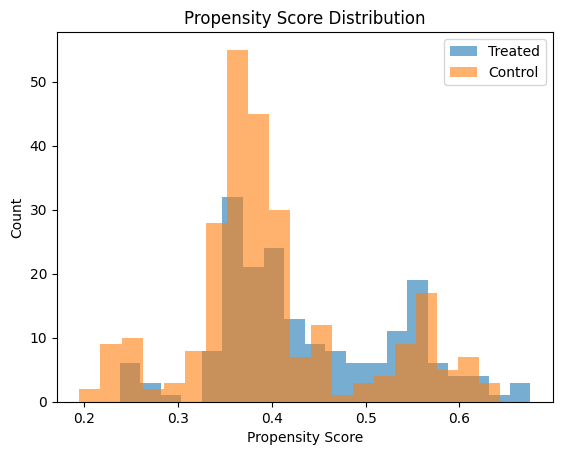

In [16]:
# 3. Visualize pscore overlap
plot_pscore_histograms(lalonde, 'pscore', treat_col)

In [18]:
# 4. Matching (1:1)
treated, matched_controls = nearest_neighbor_match(lalonde, 'pscore', treat_col, k_neighbors=1)


In [19]:
# 5. ATT (mean diff after matching)
att = calculate_att(treated, matched_controls, outcome_col)
print(f"PSM ATT (1:1): {att:.2f}")


PSM ATT (1:1): 2514.64


## On average, individuals who participated in the job training program (the treated group) earned $2,514.64 more in 1978 than very similar individuals (in terms of observed characteristics) who did not participate in the program.



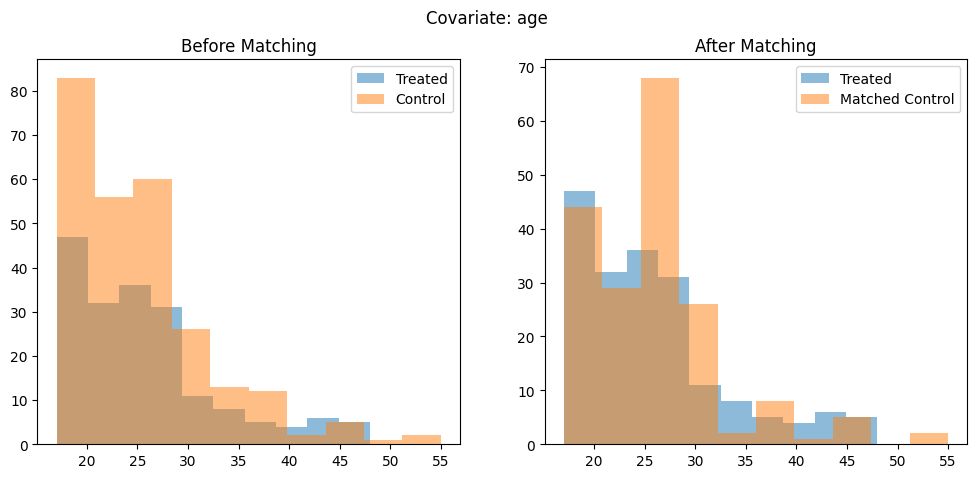

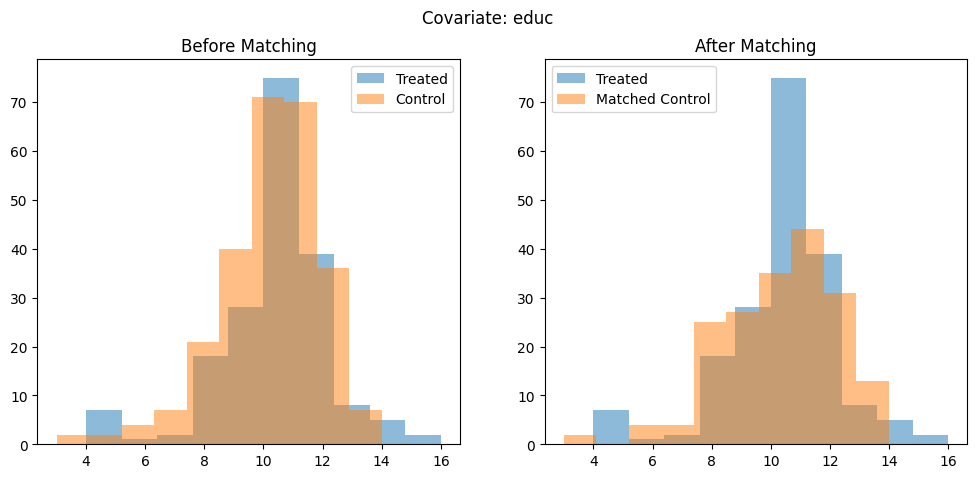

In [21]:
# 6. Plot balance for a covariate
plot_covariate_balance(lalonde, treated, matched_controls, 'age', treat_col)
plot_covariate_balance(lalonde, treated, matched_controls, 'educ', treat_col)